# Homework03 Pre-trained CNNs with Keras

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
LECTURE_ID = "HW03"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", LECTURE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# Use transfer learning for image classification, going through these steps:

- Use an existing TensorFlow Dataset. https://www.tensorflow.org/datasets

- Split it into a training set, a validation set, and a test set.

- Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

- Fine-tune a pretrained model on this dataset (e.g., ResNet50 or VGG16). https://keras.io/api/applications/ 

- Use the fine-tuned model to predict the class of a batch of images from the test set. 

Hint: Use Google Colab

### Loading TensorFlow Dataset

In [2]:
#from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [125]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model #Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense #Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD

In [3]:
# Enable eager execution
tf.enable_v2_behavior()
#Eager execution provides an imperative interface to TensorFlow. With eager execution enabled, 
#TensorFlow functions execute operations immediately (as opposed to adding to a graph to be executed later in a tf.compat.v1.Session) and return concrete values (as opposed to symbolic references to a node in a computational graph).

# Check out all available datasets 
#tfds.list_builders()

In [4]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(name = 'beans', split = ['train', 'validation', 'test'], as_supervised = True, with_info = True)
# as_supervised: if True, then it returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
# with_info: if True, it will return a tuple containing the information associated with the dataset builder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete5ITGV0/beans-train.tfrecord


  0%|          | 0/1034 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete5ITGV0/beans-validation.tfrecord


  0%|          | 0/133 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete5ITGV0/beans-test.tfrecord


  0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [6]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

### Visualize the data

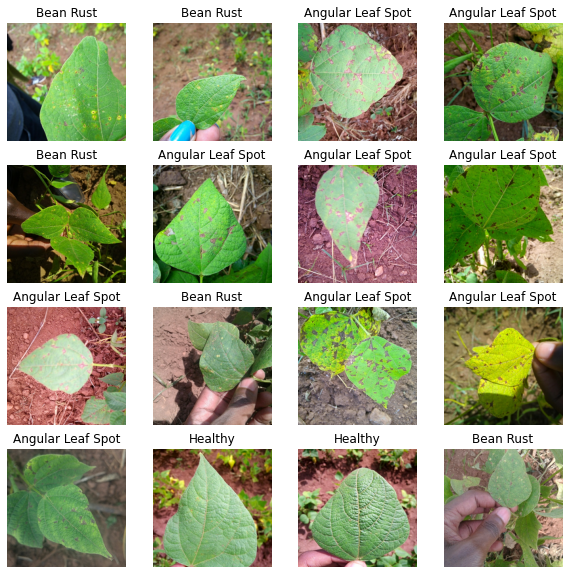

In [41]:
plt.figure(figsize=(10, 10))
i=0

for images, labels in ds_train.take(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images.numpy())
    plt.title("Angular Leaf Spot" if labels.numpy() == 0 else "Bean Rust" if labels.numpy() == 1 else "Healthy")
    plt.axis("off")
    i=i+1
    

### Standardize data and augmentation data

In [42]:
# Let's keep the dimensions the same (no resizing for now)

def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

In [ ]:
'''or use
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images'''

 ### Build the train, validation and test pipeline

In [43]:
# Pipeline hyperparameters:
batch_size = 32

In [44]:
ds_train = ds_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
# applies normalization because TFDS returns images in unit8 format while the model requires float32 format. Additionally, it resizes images given the target height and width.

ds_train = ds_train.cache()
# caches before shuffling
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# shuffles the training example to ensure randomness and prevent potential class imbalance
ds_train = ds_train.batch(batch_size)
# splits the examples into batches
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
# overlaps the preprocessing and model execution work

In [45]:
# Similarly, the validation and test pipeline were buid using similar transformations as above. 
# The main difference is that now all the batches can be the same during each epoch so we don’t shuffle the examples. Also, caching is now done after batching.

ds_validation = ds_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### Check for class imbalance

In [46]:
# Check for class imbalance and see whether there is a class (healthy, angular leaf spot disease, or bean rust disease) that contains significantly fewer samples than other classes. 

def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(ds_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(ds_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(ds_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


### Build the classification model using Transfer Learning

#### Convolutional Neural Network (CNN) - Inceptionv3

Create base model

In [ ]:
assert image_height == image_width

In [121]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history_1 = model.fit(ds_train, validation_data=ds_validation, epochs=5) #class_weight= weights_dict



Epoch 1/5
33/33 [==============================] - 689s 21s/step - loss: 1.5887 - accuracy: 0.5503 - val_loss: 0.5375 - val_accuracy: 0.7970
Epoch 2/5
33/33 [==============================] - 686s 21s/step - loss: 0.6823 - accuracy: 0.7253 - val_loss: 1.3832 - val_accuracy: 0.5940
Epoch 3/5
33/33 [==============================] - 682s 21s/step - loss: 0.5960 - accuracy: 0.7544 - val_loss: 0.5221 - val_accuracy: 0.7368
Epoch 4/5
33/33 [==============================] - 689s 21s/step - loss: 0.4949 - accuracy: 0.7950 - val_loss: 0.3685 - val_accuracy: 0.8496
Epoch 5/5
33/33 [==============================] - 689s 21s/step - loss: 0.4724 - accuracy: 0.8269 - val_loss: 0.6367 - val_accuracy: 0.6992


Fine-tuned model to predict the class of a batch of images from the test set

In [129]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
# print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 155 layers and unfreeze the rest:
for layer in model.layers[:155]: 
    layer.trainable = False
for layer in model.layers[155:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_2 = model.fit(ds_train, validation_data=ds_validation, epochs=10) #class_weight= weights_dict


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
33/33 [==============================] - 1334s 40s/step - loss: 0.8051 - accuracy: 0.6741 - val_loss: 0.3024 - val_accuracy: 0.8947
Epoch 2/10
33/33 [==============================] - 1326s 40s/step - loss: 0.3331 - accuracy: 0.8685 - val_loss: 0.2787 - val_accuracy: 0.9023
Epoch 3/10
33/33 [==============================] - 1323s 40s/step - loss: 0.2715 - accuracy: 0.9043 - val_loss: 0.2417 - val_accuracy: 0.9098
Epoch 4/10
33/33 [==============================] - 1313s 40s/step - loss: 0.2238 - accuracy: 0.9313 - val_loss: 0.2146 - val_accuracy: 0.9098
Epoch 5/10
33/33 [==============================] - 1317s 40s/step - loss: 0.1862 - accuracy: 0.9574 - val_loss: 0.1866 - val_accuracy: 0.9173
Epoch 6/10
33/33 [==============================] - 1318s 40s/step - loss: 0.1636 - accuracy: 0.9613 - val_loss: 0.1704 - val_accuracy: 0.9323
Epoch 7/10
33/33 [==============================] - 1324s 40s/step - loss: 0.1237 - accuracy: 0.9836 - val_loss: 0.1615 - val_accuracy: 0.9323

In [133]:
model.save('output\\model_hw3.h5')

In [ ]:
# model.summary()
# tf.keras.callbacks.History() #if in callbacks

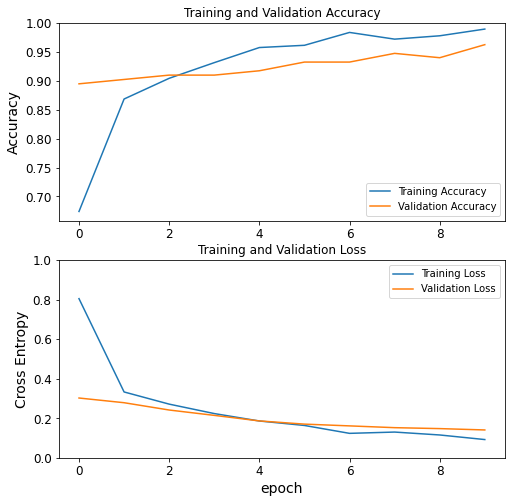

In [134]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#### Training the model and test

In [135]:
scores_inc_v3 = model.evaluate(ds_test)

4/4 [==============================] - 75s 19s/step - loss: 0.2296 - accuracy: 0.8906


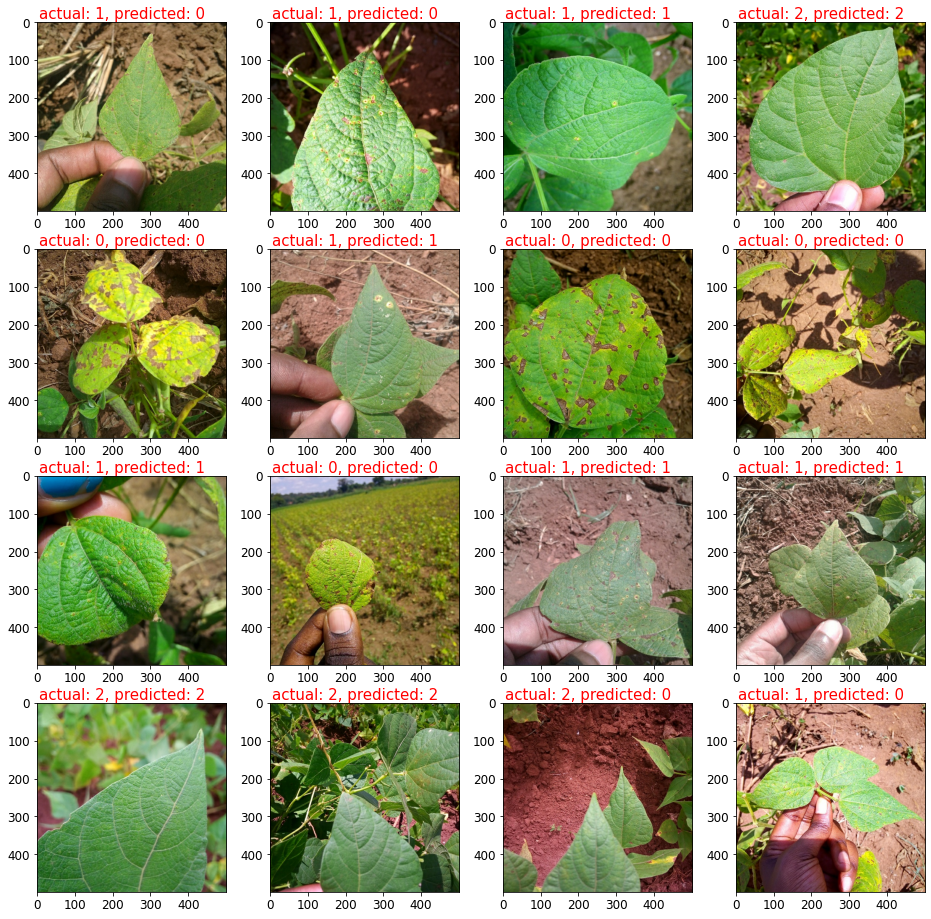

In [136]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
normalized_probs = probability_model.predict(ds_test)
predicted_labels = np.argmax(normalized_probs, axis = 1)
actual_labels = return_class_labels(ds_test)

# Looking at test images
example = ds_test.take(1)
for sample in example:
    image = sample[0]
    image = image.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "actual: " + str(actual_labels[i]) + ", predicted: " + str(predicted_labels[i]) ,
            color = 'red', fontsize = 15)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))